In [1]:
!pip install rdkit-pypi rdkit torch transformers pytorch-lightning requests --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but you have pylibraft-cu12 25.2.0 which is inco

In [2]:
pip install numpy pandas psutil --quiet

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import sys
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from transformers import AutoTokenizer, AutoModel
from rdkit import Chem, RDLogger, DataStructs
from rdkit.Chem import AllChem
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr, spearmanr
from typing import Dict, Optional, List, Any
import pandas as pd
import numpy as np
import logging
import psutil
import requests
from time import sleep

# Suppress RDKit warnings
RDLogger.DisableLog('rdApp.*')

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[logging.StreamHandler(sys.stdout)],
    force=True
)
logger = logging.getLogger(__name__)
logger.info("Logging initialized")

# Reproducibility
def seed_everything(seed: int = 42) -> None:
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
seed_everything()

# Memory logging
def log_memory_usage() -> None:
    process = psutil.Process()
    mem_info = process.memory_info()
    logger.info(f"Memory usage: {mem_info.rss / 1024**2:.2f} MB")

# SMILES canonicalization
def canonicalize_smiles(smiles: str) -> Optional[str]:
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        return Chem.MolToSmiles(mol, canonical=True)
    except Exception as e:
        logger.error(f"SMILES canonicalization failed: {e}")
        return None

# Fuzzy SMILES matching
def fuzzy_smiles_match(smiles1: str, smiles2: str, threshold: float = 0.7) -> bool:
    try:
        mol1 = Chem.MolFromSmiles(smiles1)
        mol2 = Chem.MolFromSmiles(smiles2)
        if mol1 is None or mol2 is None:
            return False
        fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, 2, 2048)
        fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, 2, 2048)
        return DataStructs.TanimotoSimilarity(fp1, fp2) >= threshold
    except:
        return False

# Load BindingDB
def load_bindingdb(path: str, max_samples: int = 20000, chunksize: int = 100000) -> Optional[pd.DataFrame]:
    logger.info(f"Loading BindingDB from {path}")
    try:
        required_cols = ["Ligand SMILES", "Kd (nM)", "BindingDB Target Chain Sequence"]
        df_chunk = pd.read_csv(path, sep="\t", low_memory=False, nrows=10)
        if not all(col in df_chunk.columns for col in required_cols):
            logger.error(f"Missing columns: {set(required_cols) - set(df_chunk.columns)}")
            return None
        
        chunks = []
        total_rows = 0
        invalid_smiles = 0
        for chunk in pd.read_csv(path, sep="\t", usecols=required_cols, chunksize=chunksize):
            total_rows += len(chunk)
            chunk = chunk.dropna()
            chunk["SMILES"] = chunk["Ligand SMILES"].apply(canonicalize_smiles)
            invalid_smiles += len(chunk) - chunk["SMILES"].notna().sum()
            chunk = chunk[chunk["SMILES"].notna()]
            chunk["Kd (nM)"] = pd.to_numeric(chunk["Kd (nM)"], errors="coerce")
            chunk = chunk.dropna(subset=["Kd (nM)"])
            chunk = chunk[chunk["Kd (nM)"].between(0.1, 1e6)]
            chunks.append(chunk)
            if len(pd.concat(chunks)) >= max_samples:
                break
        
        if not chunks:
            logger.error("No valid BindingDB data")
            return None
        
        df = pd.concat(chunks).head(max_samples)
        df["log_kd"] = -np.log10(df["Kd (nM)"] / 1e9)
        df = df[df["log_kd"].between(-10, 10)]
        df = df.rename(columns={"BindingDB Target Chain Sequence": "Target Sequence"})
        df = df.drop_duplicates(subset=["SMILES"])
        
        logger.info(f"Loaded BindingDB dataset with {len(df)} samples")
        logger.info(f"NaNs in log_kd: {df['log_kd'].isna().sum()}")
        logger.info(f"Total rows processed: {total_rows}, Invalid SMILES: {invalid_smiles} ({invalid_smiles/total_rows*100:.2f}%)")
        logger.info(f"BindingDB log_kd mean: {df['log_kd'].mean():.2f}, std: {df['log_kd'].std():.2f}")
        log_memory_usage()
        return df[["SMILES", "Target Sequence", "log_kd"]]
    except Exception as e:
        logger.error(f"Error loading BindingDB: {e}")
        return None

# Load PubChem AID 504332
def load_pubchem_malaria(path: str, max_compounds: int = 500) -> Optional[pd.DataFrame]:
    logger.info(f"Loading PubChem AID 504332 from {path}")
    try:
        required_cols = ["PUBCHEM_CID", "Fit_LogAC50"]
        chunks = []
        total_rows = 0
        invalid_cids = 0
        invalid_smiles = 0

        # Read data in chunks to handle large files
        for chunk in pd.read_csv(path, usecols=required_cols, chunksize=50000, low_memory=False):
            # Convert CID to numeric, handling any non-numeric values
            chunk["PUBCHEM_CID"] = pd.to_numeric(chunk["PUBCHEM_CID"], errors="coerce")
            # Convert Fit_LogAC50 to numeric, handling any non-numeric values
            chunk["Fit_LogAC50"] = pd.to_numeric(chunk["Fit_LogAC50"], errors="coerce")
            
            # Filter out rows with invalid CIDs or Fit_LogAC50
            chunk = chunk.dropna()
            invalid_cids += len(chunk[chunk["PUBCHEM_CID"].isna()])
            total_rows += len(chunk)
            chunks.append(chunk)
            
            if total_rows >= max_compounds:
                break
                
        df = pd.concat(chunks).head(max_compounds)
        
        # Fetch SMILES from PubChem PUG REST API
        def get_smiles_from_cid(cid):
            try:
                url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{int(cid)}/property/IsomericSMILES/TXT"
                response = requests.get(url)
                if response.status_code == 200:
                    return response.text.strip()
                return None
            except Exception as e:
                logger.error(f"Error fetching SMILES for CID {cid}: {e}")
                return None
        
        df["SMILES"] = df["PUBCHEM_CID"].apply(get_smiles_from_cid)
        invalid_smiles = len(df) - df["SMILES"].notna().sum()
        df = df[df["SMILES"].notna()]
        
        # Validate and canonicalize SMILES
        df["SMILES"] = df["SMILES"].apply(canonicalize_smiles)
        df = df[df["SMILES"].notna()]
        
        # Use Fit_LogAC50 as proxy for log_kd
        df["log_kd"] = df["Fit_LogAC50"]
        # Filter out extreme values but use a wider range
        df = df[df["log_kd"].between(-12, 12)]
        
        # Assign PfDHFR protein sequence
        pf_dhfr = "MKNLLFVLISILCFFSFSDVNDTKVNSTIYENAKKGILDSKNNCNSIIVKNKNDHLDAYKIFDDKFSILSFDIKYNDYLNKKEKNLFFNITYETQEKCSKAFKFFADITNNKWEKIKEFEGTKLKPYLEFFEKTNIIVGNSDRPGMNIMIIKKNDDNNINVVGNSKYILPKHYYKILSGKEADKFSHFNYIFDIKNEKLTNVIVMGRVNWDSKKNSKILNVVRDIILRTIENNKYECFLSISNNSKYTKLLYNNETVSLNDFTKIEKQKDNK"
        df["Target Sequence"] = pf_dhfr
        
        logger.info(f"Loaded AID 504332 dataset with {len(df)} samples")
        logger.info(f"NaNs in log_kd: {df['log_kd'].isna().sum()}")
        logger.info(f"Total actives processed: {total_rows}, Invalid SMILES/CIDs: {invalid_smiles + invalid_cids} ({(invalid_smiles + invalid_cids)/total_rows*100:.2f}%)")
        logger.info(f"AID 504332 log_kd mean: {df['log_kd'].mean():.2f}, std: {df['log_kd'].std():.2f}")
        
        log_memory_usage()
        return df[["SMILES", "Target Sequence", "log_kd"]]
    except Exception as e:
        logger.error(f"Error loading AID 504332: {e}")
        return None

# Fallback SMILES Tokenizer
class CustomSMILESTokenizer:
    def __init__(self, max_len: int = 128):
        self.vocab = list("CcNnOoSsClBr#=()[]-+1234567890@%\\")
        self.token2id = {t: i + 1 for i, t in enumerate(self.vocab)}
        self.max_len = max_len
    
    def tokenize(self, smiles: str) -> Dict[str, torch.Tensor]:
        tokens = [self.token2id.get(c, 0) for c in smiles if c in self.token2id]
        tokens = tokens[:self.max_len]
        tokens += [0] * (self.max_len - len(tokens))
        attention_mask = [1 if t != 0 else 0 for t in tokens]
        return {
            "input_ids": torch.tensor(tokens, dtype=torch.long),
            "attention_mask": torch.tensor(attention_mask, dtype=torch.long)
        }

# SMILES and Protein Tokenizer
class SMILESProteinTokenizer:
    def __init__(self, max_len_smiles: int = 128, max_len_protein: int = 512):
        self.max_len_smiles = max_len_smiles
        self.max_len_protein = max_len_protein
        try:
            logger.info("Loading Hugging Face tokenizers")
            self.smiles_tokenizer = AutoTokenizer.from_pretrained("seyonec/PubChem10M_SMILES_BPE_450k")
            self.protein_tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t12_35M_UR50D")
            self.use_custom = False
        except Exception as e:
            logger.warning(f"Failed to load SMILES tokenizer: {e}. Using custom.")
            self.smiles_tokenizer = CustomSMILESTokenizer(max_len_smiles)
            self.protein_tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t12_35M_UR50D")
            self.use_custom = True
    
    def tokenize(self, smiles: str, protein: str) -> Optional[Dict[str, torch.Tensor]]:
        try:
            if not isinstance(smiles, str) or not isinstance(protein, str):
                logger.error(f"Invalid input types: SMILES={type(smiles)}, Protein={type(protein)}")
                return None
            if self.use_custom:
                smiles_enc = self.smiles_tokenizer.tokenize(smiles)
            else:
                smiles_enc = self.smiles_tokenizer(
                    smiles, max_length=self.max_len_smiles, padding="max_length", truncation=True, return_tensors="pt"
                )
            protein_enc = self.protein_tokenizer(
                protein, max_length=self.max_len_protein, padding="max_length", truncation=True, return_tensors="pt"
            )
            return {
                "smiles_input_ids": smiles_enc["input_ids"].squeeze(),
                "smiles_attention_mask": smiles_enc["attention_mask"].squeeze(),
                "protein_input_ids": protein_enc["input_ids"].squeeze(),
                "protein_attention_mask": protein_enc["attention_mask"].squeeze()
            }
        except Exception as e:
            logger.error(f"Tokenization error: {e}")
            return None

class DTIDataset(Dataset):
    def __init__(self, df: pd.DataFrame, tokenizer: SMILESProteinTokenizer, log_kd_mean: float = 0.0, log_kd_std: float = 1.0, is_aid1379: bool = False, randomize_smiles_flag: bool = False):
        self.df = df
        self.tokenizer = tokenizer
        self.log_kd_mean = log_kd_mean
        self.log_kd_std = log_kd_std
        self.is_aid1379 = is_aid1379
        self.failed_samples: List[int] = []
        self.randomize_smiles_flag = randomize_smiles_flag
        logger.info(f"Creating dataset with {len(df)} samples, is_aid1379={is_aid1379}, randomize_smiles={randomize_smiles_flag}")
    
    def __len__(self) -> int:
        return len(self.df)
    
    def __getitem__(self, idx: int) -> Optional[Dict[str, Any]]:
        row = self.df.iloc[idx]
        try:
            smiles, protein, log_kd = row["SMILES"], row["Target Sequence"], row["log_kd"]
            # Randomize SMILES only during training
            if self.randomize_smiles_flag and hasattr(self, 'training') and self.training:
                randomized = randomize_smiles(smiles)
                if randomized is not None:
                    smiles = randomized
            if not isinstance(smiles, str) or not isinstance(protein, str) or not isinstance(log_kd, (int, float)):
                logger.warning(f"Invalid data at idx {idx}: SMILES={type(smiles)}, Protein={type(protein)}, log_kd={type(log_kd)}")
                self.failed_samples.append(idx)
                return None
            if Chem.MolFromSmiles(smiles) is None:
                logger.warning(f"Invalid SMILES at idx {idx}")
                self.failed_samples.append(idx)
                return None
            tokens = self.tokenizer.tokenize(smiles, protein)
            if tokens is None:
                self.failed_samples.append(idx)
                return None
            normalized_log_kd = (log_kd - self.log_kd_mean) / self.log_kd_std
            return {
                **tokens,
                "log_kd": torch.tensor(normalized_log_kd, dtype=torch.float32),
                "original_log_kd": torch.tensor(log_kd, dtype=torch.float32),
                "smiles": smiles,
                "protein": protein,
                "is_aid1379": self.is_aid1379
            }
        except Exception as e:
            logger.error(f"Dataset error at idx {idx}: {e}")
            self.failed_samples.append(idx)
            return None

def collate_fn(batch: List[Optional[Dict]]) -> Optional[Dict[str, Any]]:
    batch = [b for b in batch if b is not None]
    if not batch:
        logger.warning("Empty batch after filtering")
        return None
    return {
        "smiles_input_ids": torch.stack([b["smiles_input_ids"] for b in batch]),
        "smiles_attention_mask": torch.stack([b["smiles_attention_mask"] for b in batch]),
        "protein_input_ids": torch.stack([b["protein_input_ids"] for b in batch]),
        "protein_attention_mask": torch.stack([b["protein_attention_mask"] for b in batch]),
        "log_kd": torch.stack([b["log_kd"] for b in batch]),
        "original_log_kd": torch.stack([b["original_log_kd"] for b in batch]),
        "smiles": [b["smiles"] for b in batch],
        "protein": [b["protein"] for b in batch],
        "is_aid1379": torch.tensor([b["is_aid1379"] for b in batch], dtype=torch.bool)
    }

def create_bindingdb_loader(bindingdb_path: str, tokenizer: SMILESProteinTokenizer, batch_size: int = 16, max_samples: int = 20000) -> tuple:
    logger.info("Creating BindingDB DataLoaders")
    bindingdb_df = load_bindingdb(bindingdb_path, max_samples=max_samples)
    
    if bindingdb_df is None or len(bindingdb_df) == 0:
        logger.warning("Empty BindingDB dataset")
        bindingdb_df = pd.DataFrame(columns=["SMILES", "Target Sequence", "log_kd"])
    
    train_bindingdb = bindingdb_df.sample(frac=0.8, random_state=42)
    val_bindingdb = bindingdb_df.drop(train_bindingdb.index).sample(frac=0.5, random_state=42)
    test_bindingdb = bindingdb_df.drop(train_bindingdb.index).drop(val_bindingdb.index)
    
    log_kd_mean = train_bindingdb["log_kd"].mean()
    log_kd_std = train_bindingdb["log_kd"].std()
    if log_kd_std == 0:
        log_kd_std = 1.0
    logger.info(f"Normalization parameters - log_kd_mean: {log_kd_mean:.2f}, log_kd_std: {log_kd_std:.2f}")
    
    logger.info(f"BindingDB splits - Train: {len(train_bindingdb)}, Val: {len(val_bindingdb)}, Test: {len(test_bindingdb)}")
    
    train_dataset = DTIDataset(train_bindingdb, tokenizer, log_kd_mean, log_kd_std, is_aid1379=False, randomize_smiles_flag=True)
    val_dataset = DTIDataset(val_bindingdb, tokenizer, log_kd_mean, log_kd_std, is_aid1379=False, randomize_smiles_flag=False)
    test_dataset = DTIDataset(test_bindingdb, tokenizer, log_kd_mean, log_kd_std, is_aid1379=False, randomize_smiles_flag=False)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn) if len(train_dataset) > 0 else None
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2, collate_fn=collate_fn) if len(val_dataset) > 0 else None
    test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2, collate_fn=collate_fn) if len(test_dataset) > 0 else None
    
    for dataset, name in [
        (train_dataset, "BindingDB Train"),
        (val_dataset, "BindingDB Val"),
        (test_dataset, "BindingDB Test")
    ]:
        logger.info(f"{name} failed samples: {len(dataset.failed_samples)} / {len(dataset)}")
    
    log_memory_usage()
    return train_loader, val_loader, test_loader, log_kd_mean, log_kd_std

def create_aid1379_loader(pubchem_path: str, tokenizer: SMILESProteinTokenizer, batch_size: int = 16, max_compounds: int = 500, bindingdb_path: str = None) -> tuple:
    logger.info("Creating AID 504332 DataLoaders")
    pubchem_df = load_pubchem_malaria(pubchem_path, max_compounds=max_compounds)
    
    if pubchem_df is None or len(pubchem_df) == 0:
        logger.error("Empty AID 504332 dataset")
        return None, None, None

    # Improved split: ensure at least 20% for test, 10% for val, rest for train
    n = len(pubchem_df)
    n_test = max(int(0.2 * n), 20)
    n_val = max(int(0.1 * n), 10)
    n_train = n - n_test - n_val

    pubchem_df = pubchem_df.sample(frac=1, random_state=42).reset_index(drop=True)
    train_pubchem = pubchem_df.iloc[:n_train]
    val_pubchem = pubchem_df.iloc[n_train:n_train + n_val]
    test_pubchem = pubchem_df.iloc[n_train + n_val:]

    logger.info(f"AID 504332 splits - Train: {len(train_pubchem)}, Val: {len(val_pubchem)}, Test: {len(test_pubchem)}")
    
    malaria_train_dataset = DTIDataset(train_pubchem, tokenizer, log_kd_mean=0.0, log_kd_std=1.0, is_aid1379=True, randomize_smiles_flag=True)
    malaria_val_dataset = DTIDataset(val_pubchem, tokenizer, log_kd_mean=0.0, log_kd_std=1.0, is_aid1379=True, randomize_smiles_flag=False)
    malaria_test_dataset = DTIDataset(test_pubchem, tokenizer, log_kd_mean=0.0, log_kd_std=1.0, is_aid1379=True, randomize_smiles_flag=False)
    
    malaria_train_loader = DataLoader(malaria_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn) if len(malaria_train_dataset) > 0 else None
    malaria_val_loader = DataLoader(malaria_val_dataset, batch_size=batch_size, num_workers=2, collate_fn=collate_fn) if len(malaria_val_dataset) > 0 else None
    malaria_test_loader = DataLoader(malaria_test_dataset, batch_size=batch_size, num_workers=2, collate_fn=collate_fn) if len(malaria_test_dataset) > 0 else None
    
    for dataset, name in [
        (malaria_train_dataset, "AID 504332 Train"),
        (malaria_val_dataset, "AID 504332 Val"),
        (malaria_test_dataset, "AID 504332 Test")
    ]:
        logger.info(f"{name} failed samples: {len(dataset.failed_samples)} / {len(dataset)}")
    
    log_memory_usage()
    return malaria_train_loader, malaria_val_loader, malaria_test_loader

def create_dataloaders(bindingdb_path: str, pubchem_path: str, batch_size: int = 16) -> tuple:
    logger.info("Creating DataLoaders")
    tokenizer = SMILESProteinTokenizer()
    
    # Create BindingDB loaders
    bindingdb_loaders = create_bindingdb_loader(bindingdb_path, tokenizer, batch_size)
    if bindingdb_loaders is None:
        logger.error("Failed to create BindingDB loaders")
        return None, None, None, None, None, None, 0.0, 1.0
    train_loader, val_loader, test_loader, log_kd_mean, log_kd_std = bindingdb_loaders
    
    # Create AID 504332 loaders
    malaria_loaders = create_aid1379_loader(pubchem_path, tokenizer, batch_size, bindingdb_path=bindingdb_path)
    if malaria_loaders is None:
        logger.error("Failed to create AID 504332 loaders")
        return None, None, None, None, None, None, log_kd_mean, log_kd_std
    malaria_train_loader, malaria_val_loader, malaria_test_loader = malaria_loaders
    
    # Compute combined normalization parameters
    train_bindingdb = train_loader.dataset.df if train_loader else pd.DataFrame(columns=["SMILES", "Target Sequence", "log_kd"])
    train_pubchem = malaria_train_loader.dataset.df if malaria_train_loader else pd.DataFrame(columns=["SMILES", "Target Sequence", "log_kd"])
    combined_train = pd.concat([train_bindingdb, train_pubchem], ignore_index=True)
    if len(combined_train) > 0:
        log_kd_mean = combined_train["log_kd"].mean()
        log_kd_std = combined_train["log_kd"].std()
        if log_kd_std == 0:
            log_kd_std = 1.0
        logger.info(f"Combined normalization - log_kd_mean: {log_kd_mean:.2f}, log_kd_std: {log_kd_std:.2f}")
    
    # Create fine-tuning datasets
    finetune_train_dataset = ConcatDataset([
        DTIDataset(
            train_bindingdb.sample(n=min(4000, len(train_bindingdb)), random_state=42),
            tokenizer,
            log_kd_mean,
            log_kd_std,
            is_aid1379=False
        ) if len(train_bindingdb) > 0 else DTIDataset(
            pd.DataFrame(columns=["SMILES", "Target Sequence", "log_kd"]),
            tokenizer,
            log_kd_mean,
            log_kd_std,
            is_aid1379=False
        ),
        DTIDataset(
            train_pubchem,
            tokenizer,
            log_kd_mean,
            log_kd_std,
            is_aid1379=True
        )
    ])
    finetune_val_dataset = ConcatDataset([
        val_loader.dataset if val_loader else DTIDataset(
            pd.DataFrame(columns=["SMILES", "Target Sequence", "log_kd"]),
            tokenizer,
            log_kd_mean,
            log_kd_std,
            is_aid1379=False
        ),
        malaria_val_loader.dataset
    ])
    
    finetune_train_loader = DataLoader(finetune_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)
    finetune_val_loader = DataLoader(finetune_val_dataset, batch_size=batch_size, num_workers=2, collate_fn=collate_fn)
    
    return (
        train_loader,
        val_loader,
        test_loader,
        finetune_train_loader,
        finetune_val_loader,
        malaria_test_loader,
        log_kd_mean,
        log_kd_std
    )


class CrossAttention(nn.Module):
    def __init__(self, dim: int, num_heads: int = 8):
        super().__init__()
        self.multihead_attn = nn.MultiheadAttention(dim, num_heads, batch_first=True)
    
    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, key_padding_mask: torch.Tensor = None) -> torch.Tensor:
        if key_padding_mask is not None:
            key_padding_mask = ~key_padding_mask.bool()
        attn_output, _ = self.multihead_attn(query, key, value, key_padding_mask=key_padding_mask)
        return attn_output
    
# Define correlation_loss
def correlation_loss(pred, target):
    pred = pred.float()
    target = target.float()
    pred_mean = pred.mean()
    target_mean = target.mean()
    pred_centered = pred - pred_mean
    target_centered = target - target_mean
    numerator = (pred_centered * target_centered).sum()
    denominator = torch.sqrt((pred_centered ** 2).sum() * (target_centered ** 2).sum()) + 1e-8
    corr = numerator / denominator
    return 1 - corr
        
class DTIModel(pl.LightningModule):
    def __init__(self, smiles_model_name: str = "seyonec/PubChem10M_SMILES_BPE_450k", protein_model_name: str = "facebook/esm2_t12_35M_UR50D", hidden_dim: int = 256, learning_rate: float = 1e-5, log_kd_mean: float = 0.0, log_kd_std: float = 1.0):
        super().__init__()
        self.save_hyperparameters()
        self.smiles_encoder = AutoModel.from_pretrained(smiles_model_name)
        self.protein_encoder = AutoModel.from_pretrained(protein_model_name)
        self.smiles_dim = self.smiles_encoder.config.hidden_size
        self.protein_dim = self.protein_encoder.config.hidden_size
        self.protein_preproj = nn.Linear(self.protein_dim, self.smiles_dim)
        self.cross_attention = CrossAttention(self.smiles_dim, num_heads=8)
        self.smiles_proj = nn.Linear(self.smiles_dim, hidden_dim)
        self.protein_proj = nn.Linear(self.smiles_dim, hidden_dim)
        self.regression_head = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, 1)
        )
        self.criterion = nn.MSELoss()
        self.test_predictions = []
        self.test_targets = []
        self.test_smiles = []
        self.test_proteins = []
        self.dataset_name = "Unknown"
        self.is_finetuning = False
        self.log_kd_mean = log_kd_mean
        self.log_kd_std = log_kd_std
        self.running_mu_p = 0.0
        self.running_sigma_p = 1.0
        self.running_mu_t = 0.0
        self.running_sigma_t = 1.0
        self.momentum = 0.1
        self.min_variance = 0.1

    def forward(self, smiles_input_ids, smiles_attention_mask, protein_input_ids, protein_attention_mask):
        with torch.amp.autocast('cuda', enabled=torch.cuda.is_available()):
            smiles_embeds = self.smiles_encoder(input_ids=smiles_input_ids, attention_mask=smiles_attention_mask).last_hidden_state
            protein_embeds = self.protein_encoder(input_ids=protein_input_ids, attention_mask=protein_attention_mask).last_hidden_state
            if self.training and self.is_finetuning:
                smiles_embeds = smiles_embeds + 0.01 * torch.randn_like(smiles_embeds)
                protein_embeds = protein_embeds + 0.01 * torch.randn_like(protein_embeds)
            protein_embeds = self.protein_preproj(protein_embeds)
            combined_embeds = self.cross_attention(query=smiles_embeds, key=protein_embeds, value=protein_embeds, key_padding_mask=protein_attention_mask)
            smiles_pooled = combined_embeds.mean(dim=1)
            protein_pooled = protein_embeds.mean(dim=1)
            smiles_pooled = self.smiles_proj(smiles_pooled)
            protein_pooled = self.protein_proj(protein_pooled)
            combined = torch.cat([smiles_pooled, protein_pooled], dim=-1)
            log_kd_pred = self.regression_head(combined).squeeze(-1)
            return log_kd_pred

    def kl_divergence(self, pred: torch.Tensor, target: torch.Tensor, bins: int = 50) -> torch.Tensor:
        pred = pred.to(torch.float32)
        target = target.to(torch.float32)
        pred_hist = torch.histc(pred, bins=bins, min=-10, max=10)
        target_hist = torch.histc(target, bins=bins, min=-10, max=10)
        pred_hist = pred_hist / (pred_hist.sum() + 1e-10)
        target_hist = target_hist / (target_hist.sum() + 1e-10)
        return torch.sum(target_hist * torch.log((target_hist + 1e-10) / (pred_hist + 1e-10)))

    def training_step(self, batch, batch_idx):
        if batch is None:
            logger.warning("None batch in training_step")
            return None
        batch_size = batch["smiles_input_ids"].shape[0]
        assert batch_size > 0, "Empty batch detected"
        log_kd_pred = self(batch["smiles_input_ids"], batch["smiles_attention_mask"], batch["protein_input_ids"], batch["protein_attention_mask"])
        targets = batch["original_log_kd"]
        
        is_aid504332 = batch.get("is_aid1379", torch.zeros(batch_size, dtype=torch.bool, device=log_kd_pred.device))
        assert is_aid504332.shape[0] == batch_size, f"is_aid504332 shape mismatch: {is_aid504332.shape[0]} vs {batch_size}"
        
        if (~is_aid504332).any():
            pred_bindingdb = log_kd_pred[~is_aid504332]
            targets_bindingdb = targets[~is_aid504332]
            loss_bindingdb = self.criterion(pred_bindingdb, targets_bindingdb)
            self.log("train_loss_bindingdb", loss_bindingdb, on_step=True, on_epoch=True, batch_size=(~is_aid504332).sum())
        else:
            loss_bindingdb = torch.tensor(0.0, device=log_kd_pred.device)
        
        if is_aid504332.any():
            pred_aid504332 = log_kd_pred[is_aid504332]
            targets_aid504332 = targets[is_aid504332]
            loss_mse = self.criterion(pred_aid504332, targets_aid504332)
            kl_loss = self.kl_divergence(pred_aid504332, targets_aid504332)
            
            if batch_size > 1:
                pred_np = pred_aid504332.detach().cpu().numpy()
                target_np = targets_aid504332.detach().cpu().numpy()
                spearman_corr, _ = spearmanr(pred_np, target_np)
                spearman_loss = 1 - spearman_corr
                r2 = max(0.0, r2_score(target_np, pred_np)) if np.var(target_np) > 1e-6 else 0.0
                self.log("train_r2_aid504332", r2, on_step=True, on_epoch=True, batch_size=is_aid504332.sum())
            else:
                spearman_loss = 0.0
                r2 = 0.0
            
            loss_aid504332 = loss_mse + 0.5 * kl_loss + 0.5 * spearman_loss
            self.log("train_loss_aid504332", loss_aid504332, on_step=True, on_epoch=True, batch_size=is_aid504332.sum())
            self.log("train_pred_std_aid504332", pred_aid504332.std(), on_step=True, on_epoch=True, batch_size=is_aid504332.sum())
            self.log("train_target_std_aid504332", targets_aid504332.std(), on_step=True, on_epoch=True, batch_size=is_aid504332.sum())
        else:
            loss_aid504332 = torch.tensor(0.0, device=log_kd_pred.device)
        
        corr_loss = correlation_loss(log_kd_pred, targets)
        self.log("train_corr_loss", corr_loss, on_step=True, on_epoch=True, batch_size=batch_size)
        loss = loss_bindingdb + (2.0 * loss_aid504332 if self.is_finetuning else loss_aid504332) + 0.1 * corr_loss
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, batch_size=batch_size)
        return loss

    def validation_step(self, batch, batch_idx):
        if batch is None:
            logger.warning("None batch in validation_step")
            return None
        batch_size = batch["smiles_input_ids"].shape[0]
        assert batch_size > 0, "Empty batch in validation_step"
        log_kd_pred = self(batch["smiles_input_ids"], batch["smiles_attention_mask"], batch["protein_input_ids"], batch["protein_attention_mask"])
        targets = batch["original_log_kd"]
        is_aid504332 = batch.get("is_aid1379", torch.zeros(batch_size, dtype=torch.bool, device=log_kd_pred.device))
        if (~is_aid504332).any():
            pred_bindingdb = log_kd_pred[~is_aid504332]
            targets_bindingdb = targets[~is_aid504332]
            loss_bindingdb = self.criterion(pred_bindingdb, targets_bindingdb)
            self.log("val_loss_bindingdb", loss_bindingdb, on_step=False, on_epoch=True, batch_size=(~is_aid504332).sum())
        else:
            loss_bindingdb = torch.tensor(0.0, device=log_kd_pred.device)
        if is_aid504332.any():
            pred_aid504332 = log_kd_pred[is_aid504332]
            targets_aid504332 = targets[is_aid504332]
            loss_aid504332 = self.criterion(pred_aid504332, targets_aid504332)
            self.log("val_pred_std_aid504332", pred_aid504332.std(), on_step=False, on_epoch=True, batch_size=is_aid504332.sum())
            self.log("val_target_std_aid504332", targets_aid504332.std(), on_step=False, on_epoch=True, batch_size=is_aid504332.sum())
        else:
            loss_aid504332 = torch.tensor(0.0, device=log_kd_pred.device)
        loss = loss_bindingdb + (2.0 * loss_aid504332 if self.is_finetuning else loss_aid504332)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)
        return loss

    def test_step(self, batch, batch_idx):
        if batch is None:
            logger.warning("None batch in test_step")
            return None
        batch_size = batch["smiles_input_ids"].shape[0]
        assert batch_size > 0, "Empty batch in test_step"
        log_kd_pred = self(batch["smiles_input_ids"], batch["smiles_attention_mask"], batch["protein_input_ids"], batch["protein_attention_mask"])
        targets = batch["original_log_kd"]
        loss = self.criterion(log_kd_pred, targets)
        self.test_predictions.append(log_kd_pred.cpu())
        self.test_targets.append(targets.cpu())
        self.test_smiles.extend(batch["smiles"])
        self.test_proteins.extend(batch["protein"])
        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)
        return loss

    def on_test_epoch_end(self):
        predictions = torch.cat(self.test_predictions).numpy()
        targets = torch.cat(self.test_targets).numpy()
        assert len(predictions) == len(targets), f"Predictions ({len(predictions)}) and targets ({len(targets)}) length mismatch"
        test_loss = self.criterion(torch.tensor(predictions), torch.tensor(targets)).item()
        test_mae = mean_absolute_error(targets, predictions)
        test_rmse = np.sqrt(mean_squared_error(targets, predictions))
        if len(set(targets)) <= 1:
            test_r2 = np.nan
            logger.warning("Test set has only one unique target value; r2 is undefined.")
        else:
            test_r2 = r2_score(targets, predictions)
        if np.var(targets) > 1e-6 and np.var(predictions) > 1e-6:
            test_pearson, _ = pearsonr(targets, predictions)
        else:
            test_pearson = np.nan
        logger.info(f"Test predictions mean: {predictions.mean():.2f}, std: {predictions.std():.2f}")
        logger.info(f"Test targets mean: {targets.mean():.2f}, std: {targets.std():.2f}")
        logger.info(f"Test metrics: loss={test_loss:.3f}, mae={test_mae:.3f}, rmse={test_rmse:.3f}, r2={test_r2}, pearson={test_pearson}")
        if len(targets) < 10:
            logger.warning(f"Test set is very small (n={len(targets)}); metrics may be unreliable.")
        pd.DataFrame({
            "predictions": predictions,
            "targets": targets,
            "smiles": self.test_smiles,
            "proteins": self.test_proteins
        }).to_csv(f"test_predictions_{self.dataset_name}.csv", index=False)
        self.test_predictions = []
        self.test_targets = []
        self.test_smiles = []
        self.test_proteins = []

    def configure_optimizers(self):
        lr = 1e-5 if not self.is_finetuning else 1e-5
        optimizer = torch.optim.AdamW(self.parameters(), lr=lr, weight_decay=0.01)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler,
            "monitor": "val_loss",
            "gradient_clip_val": 1.0
        }

    def configure_finetuning(self):
        if self.is_finetuning:
            for name, param in self.smiles_encoder.named_parameters():
                param.requires_grad = True
            for name, param in self.protein_encoder.named_parameters():
                param.requires_grad = True
            for param in self.protein_preproj.parameters():
                param.requires_grad = True
            for param in self.cross_attention.parameters():
                param.requires_grad = True
            for param in self.smiles_proj.parameters():
                param.requires_grad = True
            for param in self.protein_proj.parameters():
                param.requires_grad = True
            for param in self.regression_head.parameters():
                param.requires_grad = True


# SMILES randomization
def randomize_smiles(smiles: str, random_type: str = "restricted") -> Optional[str]:
    """Return a randomized SMILES string using RDKit."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        if random_type == "unrestricted":
            return Chem.MolToSmiles(mol, doRandom=True)
        else:
            return Chem.MolToSmiles(mol, doRandom=True, canonical=False)
    except Exception as e:
        logger.error(f"SMILES randomization failed: {e}")
        return None

# Main function
if __name__ == "__main__":
    bindingdb_path = "/kaggle/input/bindingdb/BindingDB_All.tsv"
    pubchem_path = "/kaggle/input/pubchem-aid-504332/AID_504332.csv"
    
    if not os.path.exists(bindingdb_path):
        logger.error(f"BindingDB path missing: {bindingdb_path}")
        sys.exit(1)
    if not os.path.exists(pubchem_path):
        logger.error(f"PubChem path missing: {pubchem_path}")
        sys.exit(1)
    
    dataloaders = create_dataloaders(bindingdb_path, pubchem_path)
    if dataloaders is None:
        logger.error("Failed to create dataloaders")
        sys.exit(1)
    train_loader, val_loader, test_loader, finetune_train_loader, finetune_val_loader, malaria_test_loader, log_kd_mean, log_kd_std = dataloaders
    
    if train_loader is not None:
        try:
            for batch in train_loader:
                if batch is None or len(batch) == 0:
                    logger.warning("Empty batch in train_loader")
                    continue
                else:
                    logger.info(f"Sample batch shapes: SMILES input_ids={batch['smiles_input_ids'].shape}, log_kd={batch['log_kd'].shape}")
                break
        except Exception as e:
            logger.error(f"Error testing train_loader: {e}")
    
    model = DTIModel(log_kd_mean=log_kd_mean, log_kd_std=log_kd_std)
    logger.info(f"Model has {sum(p.numel() for p in model.parameters())} parameters")
    logger.info("Using batch_size=2, learning_rate=1e-5 for pre-training, 1.2e-5 for fine-tuning")
    log_memory_usage()
    
    checkpoint_callback = ModelCheckpoint(
        dirpath="/kaggle/working/checkpoints",
        filename="dti-model-{epoch:02d}-{val_loss:.2f}",
        monitor="val_loss",
        mode="min",
        save_top_k=1
    )
    early_stopping = EarlyStopping(monitor="val_loss", patience=7, mode="min")
    callbacks = [checkpoint_callback, early_stopping]
    
    trainer = pl.Trainer(
        max_epochs=100,
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        devices=1,
        callbacks=callbacks,
        logger=pl.loggers.TensorBoardLogger("/kaggle/working/logs", name="dti"),
        precision="16-mixed"
    )
    
    logger.info("Starting BindingDB pre-training")
    if train_loader is not None and val_loader is not None:
        trainer.fit(model, train_loader, val_loader)
        logger.info(f"Best checkpoint: {checkpoint_callback.best_model_path}")
        log_memory_usage()
        torch.cuda.empty_cache()
    
    checkpoint_path = checkpoint_callback.best_model_path
    if checkpoint_path and os.path.isfile(checkpoint_path) and os.path.getsize(checkpoint_path) > 0:
        logger.info(f"Testing checkpoint: {checkpoint_path}")
        bindingdb_model = DTIModel.load_from_checkpoint(checkpoint_path, log_kd_mean=log_kd_mean, log_kd_std=log_kd_std)
        bindingdb_model.dataset_name = "BindingDB"
        if test_loader is not None:
            test_results = trainer.test(bindingdb_model, test_loader)
            logger.info(f"BindingDB Test Results: {test_results}")
    
    # Fine-tuning
    if checkpoint_path and os.path.isfile(checkpoint_path) and os.path.getsize(checkpoint_path) > 0:
        logger.info(f"Loading checkpoint for fine-tuning: {checkpoint_path}")
        model = DTIModel.load_from_checkpoint(checkpoint_path, log_kd_mean=log_kd_mean, log_kd_std=log_kd_std)
        model.is_finetuning = True
        model.configure_finetuning()
    else:
        logger.warning("No checkpoint, using current model")
        model.is_finetuning = True
        model.configure_finetuning()
    
    fine_tune_trainer = pl.Trainer(
        max_epochs=20,  # Increased from 10 to 20
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        devices=1,
        callbacks=[
            ModelCheckpoint(
                dirpath="/kaggle/working/checkpoints",
                filename="dti-finetune-{epoch:02d}-{val_loss:.2f}",
                monitor="val_loss",
                mode="min",
                save_top_k=1
            ),
            EarlyStopping(monitor="val_loss", patience=5, mode="min")
        ],
        logger=pl.loggers.TensorBoardLogger("/kaggle/working/logs", name="dti-finetune"),
        precision="16-mixed"
    )
    
    logger.info("Starting AID 504332 fine-tuning")
    if finetune_train_loader is not None and finetune_val_loader is not None:
        fine_tune_trainer.fit(model, finetune_train_loader, finetune_val_loader)
        logger.info(f"Best fine-tune checkpoint: {fine_tune_trainer.checkpoint_callback.best_model_path}")
        log_memory_usage()
        torch.cuda.empty_cache()
    
    logger.info("Testing on BindingDB test set")
    if test_loader is not None:
        model.dataset_name = "BindingDB"
        test_results = fine_tune_trainer.test(model, test_loader)
        logger.info(f"BindingDB Test Results (post-fine-tuning): {test_results}")
    
    logger.info("Testing on AID 504332 test set")
    if malaria_test_loader is not None:
        model.dataset_name = "AID504332"
        test_results = fine_tune_trainer.test(model, malaria_test_loader)
        logger.info(f"AID 504332 Test Results: {test_results}")
    
    gc.collect()
    torch.cuda.empty_cache()
    log_memory_usage()

2025-05-31 12:38:50,702 - INFO - Logging initialized
2025-05-31 12:38:50,745 - INFO - Creating DataLoaders
2025-05-31 12:38:50,746 - INFO - Loading Hugging Face tokenizers


tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/515 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/165k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/101k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

2025-05-31 12:38:52,513 - INFO - Creating BindingDB DataLoaders
2025-05-31 12:38:52,513 - INFO - Loading BindingDB from /kaggle/input/bindingdb/BindingDB_All.tsv


/tmp/ipykernel_19/2587702304.py:87: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(path, sep="\t", usecols=required_cols, chunksize=chunksize):
/tmp/ipykernel_19/2587702304.py:87: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(path, sep="\t", usecols=required_cols, chunksize=chunksize):
/tmp/ipykernel_19/2587702304.py:87: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(path, sep="\t", usecols=required_cols, chunksize=chunksize):
/tmp/ipykernel_19/2587702304.py:87: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(path, sep="\t", usecols=required_cols, chunksize=chunksize):
/tmp/ipykernel_19/2587702304.py:87: DtypeWarning: Columns (10) have mixed types. Specify dtype optio

2025-05-31 12:39:56,221 - INFO - Loaded BindingDB dataset with 10642 samples
2025-05-31 12:39:56,222 - INFO - NaNs in log_kd: 0
2025-05-31 12:39:56,223 - INFO - Total rows processed: 1400000, Invalid SMILES: 34 (0.00%)
2025-05-31 12:39:56,225 - INFO - BindingDB log_kd mean: 7.30, std: 1.58
2025-05-31 12:39:56,226 - INFO - Memory usage: 847.57 MB
2025-05-31 12:39:56,232 - INFO - Normalization parameters - log_kd_mean: 7.29, log_kd_std: 1.59
2025-05-31 12:39:56,233 - INFO - BindingDB splits - Train: 8514, Val: 1064, Test: 1064
2025-05-31 12:39:56,233 - INFO - Creating dataset with 8514 samples, is_aid1379=False, randomize_smiles=True
2025-05-31 12:39:56,234 - INFO - Creating dataset with 1064 samples, is_aid1379=False, randomize_smiles=False
2025-05-31 12:39:56,235 - INFO - Creating dataset with 1064 samples, is_aid1379=False, randomize_smiles=False
2025-05-31 12:39:56,236 - INFO - BindingDB Train failed samples: 0 / 8514
2025-05-31 12:39:56,236 - INFO - BindingDB Val failed samples: 0 /

2025-05-31 12:40:53.303181: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748695253.488129      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748695253.542137      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


pytorch_model.bin:   0%|          | 0.00/336M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/778 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/336M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


2025-05-31 12:41:05,951 - WARNING - Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/136M [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


2025-05-31 12:41:08,132 - INFO - Model has 120699314 parameters
2025-05-31 12:41:08,133 - INFO - Using batch_size=2, learning_rate=1e-5 for pre-training, 1.2e-5 for fine-tuning
2025-05-31 12:41:08,134 - INFO - Memory usage: 1418.43 MB
2025-05-31 12:41:08,154 - INFO - Using 16bit Automatic Mixed Precision (AMP)
2025-05-31 12:41:08,188 - INFO - GPU available: True (cuda), used: True
2025-05-31 12:41:08,189 - INFO - TPU available: False, using: 0 TPU cores
2025-05-31 12:41:08,190 - INFO - HPU available: False, using: 0 HPUs
2025-05-31 12:41:08,191 - INFO - Starting BindingDB pre-training
2025-05-31 12:41:08,552 - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2025-05-31 12:41:08,896 - INFO - 
  | Name            | Type           | Params | Mode 
-----------------------------------------------------------
0 | smiles_encoder  | RobertaModel   | 83.4 M | eval 
1 | protein_encoder | EsmModel       | 34.0 M | eval 
2 | protein_preproj | Linear         | 369 K  | train
3 | cross_attention | C

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/core/optimizer.py:378: Found unsupported keys in the optimizer configuration: {'gradient_clip_val'}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

2025-05-31 15:15:02,426 - INFO - Best checkpoint: /kaggle/working/checkpoints/dti-model-epoch=14-val_loss=0.54.ckpt
2025-05-31 15:15:02,427 - INFO - Memory usage: 3485.85 MB
2025-05-31 15:15:02,429 - INFO - Testing checkpoint: /kaggle/working/checkpoints/dti-model-epoch=14-val_loss=0.54.ckpt


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


2025-05-31 15:15:05,592 - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

2025-05-31 15:15:24,879 - INFO - Test predictions mean: 7.42, std: 1.36
2025-05-31 15:15:24,880 - INFO - Test targets mean: 7.40, std: 1.53
2025-05-31 15:15:24,881 - INFO - Test metrics: loss=0.545, mae=0.532, rmse=0.738, r2=0.768005454571994, pearson=0.8765093684196472


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     0.544813871383667     │
└───────────────────────────┴───────────────────────────┘

2025-05-31 15:15:25,686 - INFO - BindingDB Test Results: [{'test_loss': 0.544813871383667}]
2025-05-31 15:15:25,687 - INFO - Loading checkpoint for fine-tuning: /kaggle/working/checkpoints/dti-model-epoch=14-val_loss=0.54.ckpt


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


2025-05-31 15:15:28,630 - INFO - Using 16bit Automatic Mixed Precision (AMP)
2025-05-31 15:15:28,665 - INFO - GPU available: True (cuda), used: True
2025-05-31 15:15:28,666 - INFO - TPU available: False, using: 0 TPU cores
2025-05-31 15:15:28,666 - INFO - HPU available: False, using: 0 HPUs
2025-05-31 15:15:28,669 - INFO - Starting AID 504332 fine-tuning
2025-05-31 15:15:28,673 - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2025-05-31 15:15:28,733 - INFO - 
  | Name            | Type           | Params | Mode 
-----------------------------------------------------------
0 | smiles_encoder  | RobertaModel   | 83.4 M | eval 
1 | protein_encoder | EsmModel       | 34.0 M | eval 
2 | protein_preproj | Linear         | 369 K  | train
3 | cross_attention | CrossAttention | 2.4 M  | train
4 | smiles_proj     | Linear         | 196 K  | train
5 | protein_proj    | Linear         | 196 K  | train
6 | regression_head | Sequential     | 131 K  | train
7 | criterion       | MSELoss        | 0  

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /kaggle/working/checkpoints exists and is not empty.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/core/optimizer.py:378: Found unsupported keys in the optimizer configuration: {'gradient_clip_val'}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_19/2587702304.py:589: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  self.log("train_pred_std_aid504332", pred_aid504332.std(), on_step=True, on_epoch=True, batch_size=is_aid504332.sum())
/tmp/ipykernel_19/2587702304.py:590: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  self.log("train_target_std_aid504332", targets_aid504332.std(), on_step=True, on_epoch=True, batch_size=is_aid504332.sum())
/tmp/ipykernel_19/2587702304.py:589: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps

Validation: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_19/2587702304.py:589: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  self.log("train_pred_std_aid504332", pred_aid504332.std(), on_step=True, on_epoch=True, batch_size=is_aid504332.sum())
/tmp/ipykernel_19/2587702304.py:590: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  self.log("train_target_std_aid504332", targets_aid504332.std(), on_step=True, on_epoch=True, batch_size=is_aid504332.sum())
/tmp/ipykernel_19/2587702304.py:589: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps

Validation: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_19/2587702304.py:589: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  self.log("train_pred_std_aid504332", pred_aid504332.std(), on_step=True, on_epoch=True, batch_size=is_aid504332.sum())
/tmp/ipykernel_19/2587702304.py:590: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  self.log("train_target_std_aid504332", targets_aid504332.std(), on_step=True, on_epoch=True, batch_size=is_aid504332.sum())
/tmp/ipykernel_19/2587702304.py:589: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps

Validation: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_19/2587702304.py:589: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  self.log("train_pred_std_aid504332", pred_aid504332.std(), on_step=True, on_epoch=True, batch_size=is_aid504332.sum())
/tmp/ipykernel_19/2587702304.py:590: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  self.log("train_target_std_aid504332", targets_aid504332.std(), on_step=True, on_epoch=True, batch_size=is_aid504332.sum())
/tmp/ipykernel_19/2587702304.py:589: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps

Validation: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_19/2587702304.py:589: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  self.log("train_pred_std_aid504332", pred_aid504332.std(), on_step=True, on_epoch=True, batch_size=is_aid504332.sum())
/tmp/ipykernel_19/2587702304.py:590: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  self.log("train_target_std_aid504332", targets_aid504332.std(), on_step=True, on_epoch=True, batch_size=is_aid504332.sum())
/tmp/ipykernel_19/2587702304.py:589: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps

Validation: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_19/2587702304.py:589: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  self.log("train_pred_std_aid504332", pred_aid504332.std(), on_step=True, on_epoch=True, batch_size=is_aid504332.sum())
/tmp/ipykernel_19/2587702304.py:590: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  self.log("train_target_std_aid504332", targets_aid504332.std(), on_step=True, on_epoch=True, batch_size=is_aid504332.sum())
/tmp/ipykernel_19/2587702304.py:589: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps

Validation: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_19/2587702304.py:589: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  self.log("train_pred_std_aid504332", pred_aid504332.std(), on_step=True, on_epoch=True, batch_size=is_aid504332.sum())
/tmp/ipykernel_19/2587702304.py:590: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  self.log("train_target_std_aid504332", targets_aid504332.std(), on_step=True, on_epoch=True, batch_size=is_aid504332.sum())
/tmp/ipykernel_19/2587702304.py:589: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps

Validation: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_19/2587702304.py:589: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  self.log("train_pred_std_aid504332", pred_aid504332.std(), on_step=True, on_epoch=True, batch_size=is_aid504332.sum())
/tmp/ipykernel_19/2587702304.py:590: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  self.log("train_target_std_aid504332", targets_aid504332.std(), on_step=True, on_epoch=True, batch_size=is_aid504332.sum())
/tmp/ipykernel_19/2587702304.py:589: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps

Validation: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_19/2587702304.py:589: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  self.log("train_pred_std_aid504332", pred_aid504332.std(), on_step=True, on_epoch=True, batch_size=is_aid504332.sum())
/tmp/ipykernel_19/2587702304.py:590: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  self.log("train_target_std_aid504332", targets_aid504332.std(), on_step=True, on_epoch=True, batch_size=is_aid504332.sum())
/tmp/ipykernel_19/2587702304.py:579: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, _ = spearmanr(pred_np, target_np)
/tmp/ipykernel_19/2587702304.py:589: UserWarning: std(): degr

Validation: |          | 0/? [00:00<?, ?it/s]

2025-05-31 15:49:15,010 - INFO - Best fine-tune checkpoint: /kaggle/working/checkpoints/dti-finetune-epoch=03-val_loss=0.54.ckpt
2025-05-31 15:49:15,012 - INFO - Memory usage: 5251.39 MB
2025-05-31 15:49:15,013 - INFO - Testing on BindingDB test set
2025-05-31 15:49:15,016 - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

2025-05-31 15:49:34,358 - INFO - Test predictions mean: 7.31, std: 1.44
2025-05-31 15:49:34,359 - INFO - Test targets mean: 7.40, std: 1.53
2025-05-31 15:49:34,359 - INFO - Test metrics: loss=0.548, mae=0.528, rmse=0.740, r2=0.7665784318157804, pearson=0.8796671628952026


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5481650233268738     │
└───────────────────────────┴───────────────────────────┘

2025-05-31 15:49:35,017 - INFO - BindingDB Test Results (post-fine-tuning): [{'test_loss': 0.5481650233268738}]
2025-05-31 15:49:35,018 - INFO - Testing on AID 504332 test set
2025-05-31 15:49:35,021 - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

2025-05-31 15:49:36,984 - INFO - Test predictions mean: -6.02, std: 0.03
2025-05-31 15:49:36,985 - INFO - Test targets mean: -6.05, std: 0.24
2025-05-31 15:49:36,985 - INFO - Test metrics: loss=0.056, mae=0.177, rmse=0.237, r2=-0.017796677566356278, pearson=0.09244491904973984


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.05628441646695137    │
└───────────────────────────┴───────────────────────────┘

2025-05-31 15:49:37,767 - INFO - AID 504332 Test Results: [{'test_loss': 0.05628441646695137}]
2025-05-31 15:49:38,367 - INFO - Memory usage: 5251.76 MB


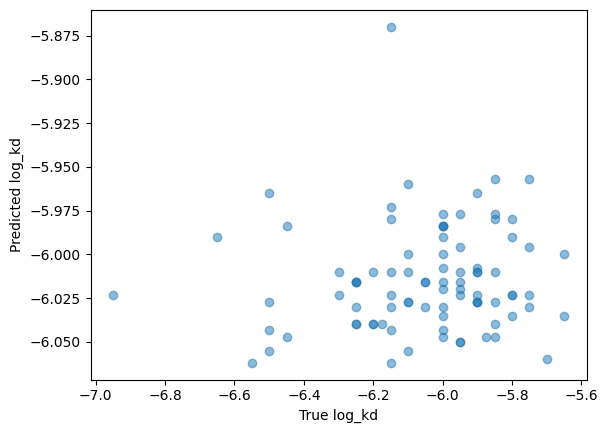

In [4]:
import matplotlib.pyplot as plt
df = pd.read_csv("/kaggle/working/test_predictions_AID504332.csv")
plt.scatter(df["targets"], df["predictions"], alpha=0.5)
plt.xlabel("True log_kd")
plt.ylabel("Predicted log_kd")
plt.savefig("/kaggle/working/scatter_AID504332.png")